# Classification. Linear models and KNN

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [6]:
PATH = "./data/"

In [7]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [8]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [9]:
males = data[data['Sex'] == 'male']
survived_males = males[males['Survived'] == 1]
females = data[data['Sex'] == 'female']
survived_females = females[females['Survived'] == 1]
print(f'Male count - {males.shape[0]}, Survived - {survived_males.shape[0]}\
, Survival rate - {(survived_males.shape[0] / males.shape[0]) * 100}%')
print(f'Female count - {females.shape[0]}, Survived - {survived_females.shape[0]}\
, Survival rate - {(survived_females.shape[0] / females.shape[0]) * 100}%')

Male count - 577, Survived - 109, Survival rate - 18.890814558058924%
Female count - 314, Survived - 233, Survival rate - 74.20382165605095%


As we can see women have bigger survival rates than men. It makes sense because as we know women had priority to get places in lifeboats.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

In [10]:
def age_hist(axs, data, title):
    axs.hist(data['Age'])
    axs.set_title(title)
    axs.axvline(data['Age'].mean(), color='k', linestyle='solid', linewidth=3, \
                   label='Average age is {:0.2f}'.format(data['Age'].mean()))
    axs.axvline(data['Age'].median(), color='k', linestyle='dotted', linewidth=3, \
                  label='Median age is {:0.2f}'.format(data['Age'].median()))
    axs.legend(loc=0)

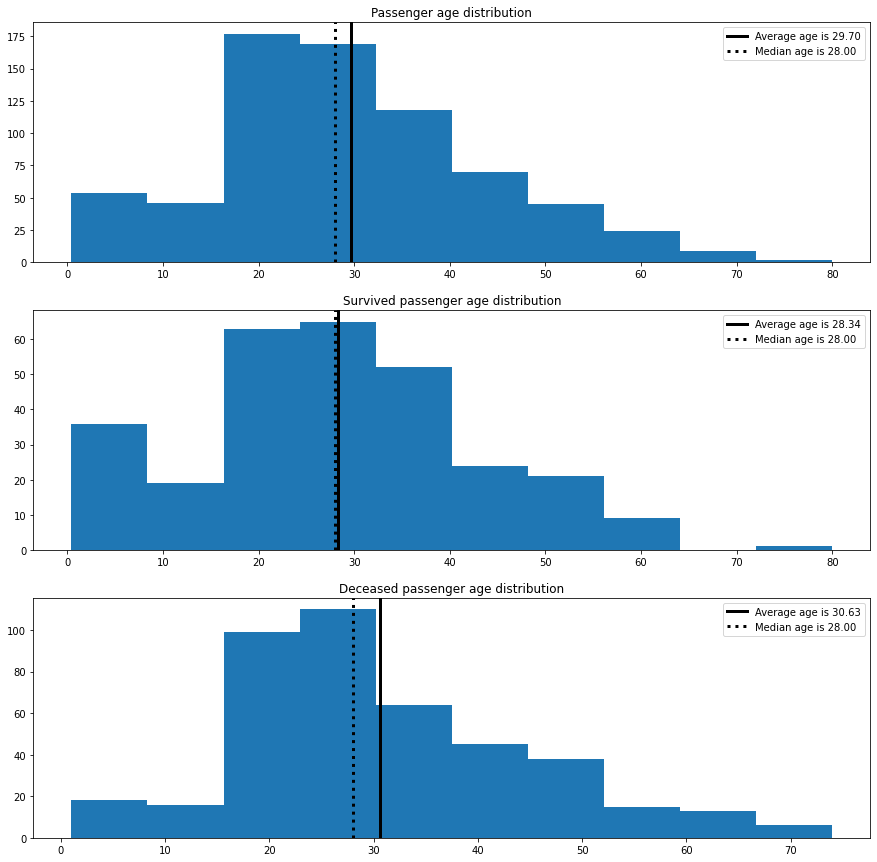

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(15,15))

age_hist(axs[0], data, 'Passenger age distribution')
age_hist(axs[1], data[data['Survived'] == 1], 'Survived passenger age distribution')
age_hist(axs[2], data[data['Survived'] == 0], 'Deceased passenger age distribution')

As we can see the count of survived children in several times more than the deceased, the opposite case for elderly persons. In my opinion, we see these numbers because people tried to rescue children. In the case of elderly people maybe they give their places in lifeboats to other people or they were rather weak to survive in this catastrophe. 

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

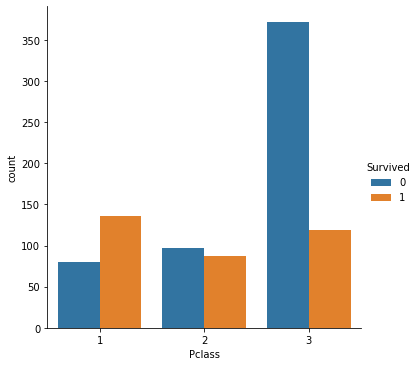

In [12]:
sns.catplot(x='Pclass', data=data, hue='Survived', kind='count')

We see that the class really influences on survival rate. The first class is the safest class, in my opinion, because expensive cabins were on the top of the boat and people who occupied them had more chances to survive.

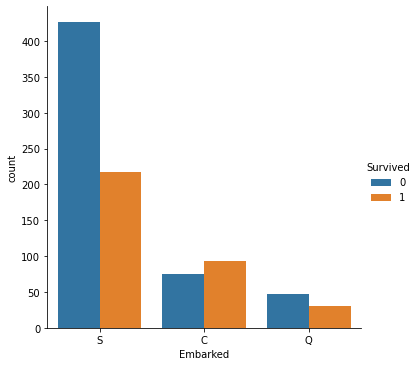

In [13]:
sns.catplot(x='Embarked', data=data, hue='Survived', kind='count')

This fact is a little bit confusing because it really unclear how embarkation port influence on survival rate. But if we look at the relation between cabin class and embarkation port we could notice that in embarkation port C boarded a lot of people from class 1.

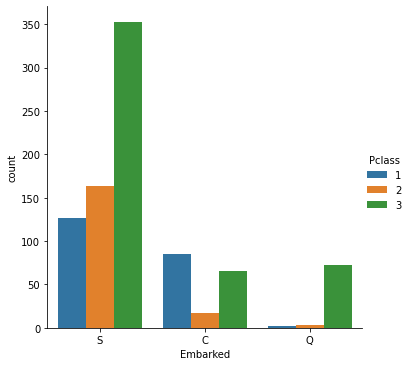

In [14]:
sns.catplot(x='Embarked', data=data, hue='Pclass', kind='count')

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [15]:
data.isna().mean().round(4) * 100

Survived     0.00
Pclass       0.00
Name         0.00
Sex          0.00
Age         19.87
SibSp        0.00
Parch        0.00
Ticket       0.00
Fare         0.00
Cabin       77.10
Embarked     0.22
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

1. We can remove some features with a high percentage of missing values. 
2. We can fill the gaps by using the average or median value.
3. We can fill the gaps by using some technics like  KNN Imputation or Multivariate imputation.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [16]:
y = data['Survived']

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Age']
X = pd.get_dummies(data[features], drop_first=True)
X['Age'] = X['Age'].fillna(value=X['Age'].mean())

lr = LogisticRegression(penalty='l2', random_state=42)
neigh = KNeighborsClassifier(n_neighbors=4)

print('Result with using Logistic Regression: {:f}'.format(cross_val_score(lr, X, 
                                                           y, scoring='accuracy', cv=5).mean()))
print('Result with using KNN: {:f}'.format(cross_val_score(neigh, X, 
                                                           y, scoring='accuracy', cv=5).mean()))

Result with using Logistic Regression: 0.783385
Result with using KNN: 0.775588


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [18]:
def process_features(data):
    features = ['Pclass', 'Sex', 'Age', 'Embarked', 'SibSp', 'Parch']
    X = data[features].copy()
    X['Age'] = X['Age'].fillna(value=X['Age'].median())
    return pd.get_dummies(X)

In [19]:
X = process_features(data)

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X, y)
print('Result with using Logistic Regression: {:f}'.format(cross_val_score(lr, X, 
                                                           y, scoring='accuracy', cv=5).mean()))

neigh = KNeighborsClassifier(n_neighbors=11, metric='manhattan', algorithm='brute')
neigh.fit(X, y)
print('Result with using KNN: {:f}'.format(cross_val_score(neigh, X, 
                                                           y, scoring='accuracy', cv=5).mean()))

Result with using Logistic Regression: 0.792367
Result with using KNN: 0.815963


Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [20]:
#Kaggle nickname - virtace, max score - 0.77272
test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
test_X = process_features(test)

predictions = lr.predict(test_X)

output = pd.DataFrame({ 'PassengerId' : test.index, 'Survived': predictions })
output.to_csv('submission.csv', index=False)

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [21]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [22]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [79]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [80]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [81]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [82]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [83]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

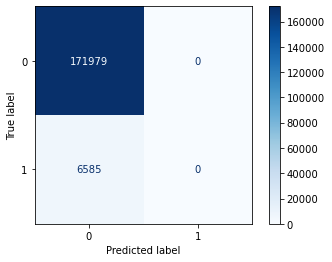

In [28]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [29]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

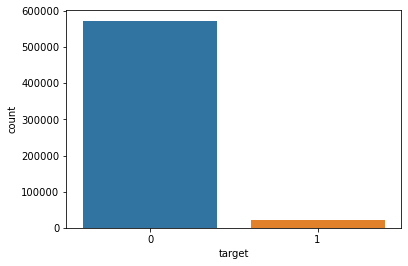

In [30]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [31]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

ROC curve builds with using the following rules:
1. By Y-axis represents the proportion of truly positive events
2. By X-axis represents the proportion of false positive events
3. Then we need to estimate the area under curve (AUC)

It can be represented by the formula::
$$AUC = \frac{1}{2}\sum\limits_{i}(y_{j+1} + y_{j})(x_{i+1} - x_{i})$$

$$y_{i} - \text{proportion of truly positive events for i-th}$$
$$x_{i} - \text{proportion of false positive events for i-th}$$

To calculate the Gini index, we investigate the dependence of the proportion of incorrectly classified positive events in the total number of positive events on the proportion of correctly classified negative events in the total number of negative events (Lorentz curve).

Lorentz curve bulds with using the following rules:
1. By Y-axis represents the proportion of negatively classified positive events (1 - TPR)
2. By X-axis represents the proportion of positively classified false events (1 - FPR)

Gini coeffcient it's the relation of the area of the figure formed by the Lorentz curve and the diagonal of the unit square to half the area of the unit square.

It can be represented by the formula:

$$Gini = 1 - \sum\limits_{i}(y_{j+1} + y_{j})(x_{i+1} - x_{i})$$

$$y_{i} - \text{proportion of misclassified positive events for i-th}$$
$$x_{i} - \text{proportion of correctly classified negative events for i-th}$$

From these formulas is obvious that the Gini coefficient and AUC related by the following expression:

$$Gini = 2 \times AUC - 1$$

We see on the chart that the Lorentz curve is centrally symmetric to the ROC curve

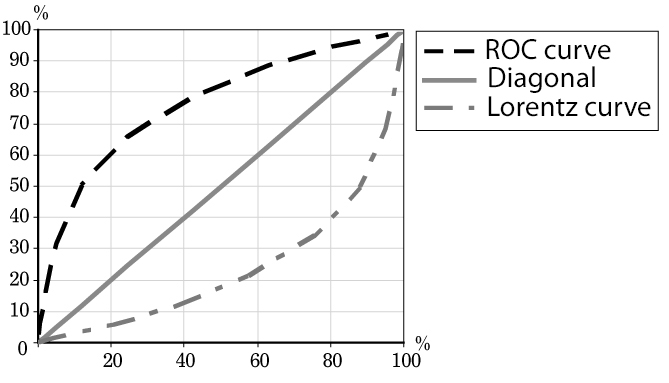

To simplify the interpretation, we will mark the areas with letters.

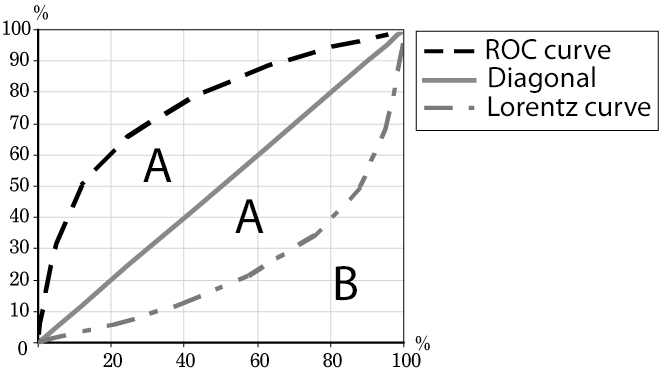

So as we know Gini coefficient it's the relation of the area of the figure formed by the Lorentz curve and the diagonal of the unit square to half the area of the unit square. It means Gini coefficient will be equal to:
$$Gini = \frac{A}{A+B}$$
where A+B is half the area of a unit square and equal to 0.5, so we can replace A + B with using this value:
$$Gini = \frac{A}{0.5}=2A$$

Also by using the similar approach we can describe the AUC value.
$$AUC = A + (A + B) = A + 0.5$$

With using this method we again see that the:
$$Gini = 2 \times AUC - 1$$

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

For imbalanced models, we can use the following metrics:
1. Precision
2. Recall
3. F-1 (F-score)
4. Cohen's kappa coefficient

Let's calculate the Normalized Gini Coefficient:

In [32]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [33]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [77]:
from sklearn.ensemble import RandomForestClassifier

reg = RandomForestClassifier(max_depth=2, random_state=42)

reg.fit(X_train, y_train)

print('Result with using Random Forest classifier: {:f}'.format(cross_val_score(reg, X_train, 
                                                           y_train, scoring='accuracy', cv=5).mean()))

Result with using Random Forest classifier: 0.963737


In [39]:
def roc_auc_chart(X_valid, y_validf, reg):
    import sklearn.metrics as metrics
    probs = reg.predict_proba(X_valid)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_valid, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

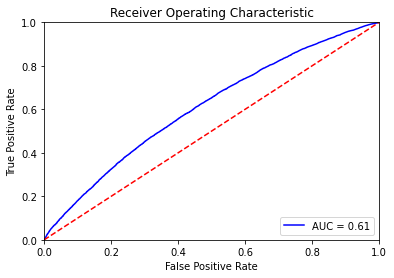

In [78]:
roc_auc_chart(X_valid, y_valid, reg)

In [35]:
pip install -U delayed

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install -U imbalanced-learn

Undersampling example:

Before undersampling:  416648
After undersampling:  30218
Result with using Random Forest classifier: 0.577337


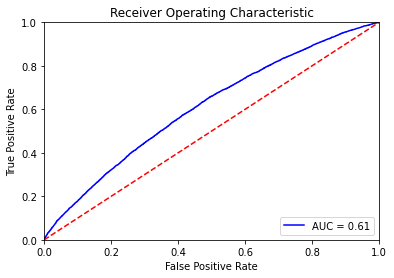

In [96]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.fixes import delayed

undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)

print("Before undersampling: ", len(y_train))

X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

print("After undersampling: ", len(y_train_under))

reg = RandomForestClassifier(max_depth=2, random_state=42)
reg.fit(X_train_under, y_train_under)

print('Result with using Random Forest classifier: {:f}'.format(cross_val_score(reg, X_train_under, 
                                                           y_train_under, scoring='accuracy', cv=5).mean()))

roc_auc_chart(X_valid, y_valid, reg)

Oversampling example:

Before oversampling:  416648
After oversampling:  803078
Result with using Random Forest classifier: 0.815377


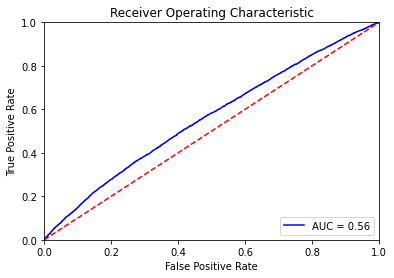

In [98]:
from imblearn.over_sampling import SMOTE

print("Before oversampling: ", len(y_train))

smote = SMOTE()

X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

print("After oversampling: ", len(y_train_SMOTE))

reg = RandomForestClassifier(max_depth=2, random_state=42)
reg.fit(X_train_SMOTE, y_train_SMOTE)

print('Result with using Random Forest classifier: {:f}'.format(cross_val_score(reg, X_train_SMOTE, 
                                                           y_train_SMOTE, scoring='accuracy', cv=5).mean()))

roc_auc_chart(X_valid, y_valid, reg)

With using both approaches

Result with using Random Forest classifier: 0.963737


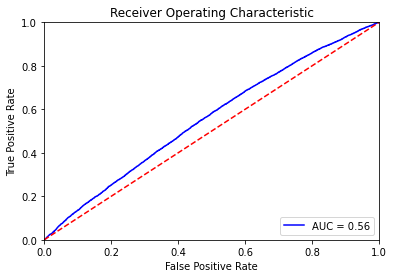

In [99]:
from imblearn.pipeline import Pipeline

reg = RandomForestClassifier(max_depth=2, random_state=42)
over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.5)
pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('o', over), ('u', under), ('model', reg)])

pipeline.fit(X_train, y_train)

print('Result with using Random Forest classifier: {:f}'.format(cross_val_score(pipeline, X_train, 
                                                           y_train, scoring='accuracy', cv=5).mean()))

roc_auc_chart(X_valid, y_valid, pipeline)


In [72]:
#Kaggle nickname - virtace, max score - 0.06327
test_X = pd.read_csv(os.path.join(PATH, 'porto', 'test.csv')).set_index('id')

predictions = pipeline.predict(test_X)

output = pd.DataFrame({ 'id' : test_X.index, 'target': predictions })
output.to_csv('submission.csv', index=False)